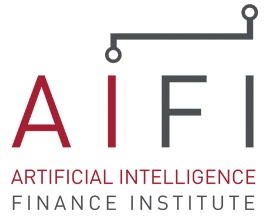


# Bootcamp - Python and Coding - Supervised Machine Learning - XAI


# About this Notebook


In this notebook we use [SHAP](https://shap.readthedocs.io/en/latest/) and [LIME](https://github.com/marcotcr/lime), [paper](https://arxiv.org/abs/1602.04938) to better understand predictions of ML models. 
- LIME stands for Local Interpretable Model-agnostic Explanations and helps to ML model predictions individually comprehensible and is suitable for local explanations. 
- Wheras SHAP, for SHapley Additive exPlanations, aims to explain the prediction of an instance/observation by computing the contribution of each feature to the prediction.

In [8]:
import numpy as np
import shap
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Using SHAP

Data Preparation: We fetch historical stock data for Apple Inc. (AAPL) from Yahoo Finance and selected features ('Open', 'Close', and 'Volume') for a 7-day lookback period. This means that we use seven consecutive days of 'Open', 'Close', and 'Volume' to predict the 'Adj Close' price on the 8th day.

In [ ]:
# Define a function to create a dataset with 'n' days lookback
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    for i in range(look_back, len(data)):
        dataX.append(data.iloc[i-look_back:i].values.flatten())
        dataY.append(data.iloc[i]['Adj Close'])
    return np.array(dataX), np.array(dataY)


In [ ]:
# Fetch and prepare the data
data = yf.download('AAPL', start='2021-01-01', end='2022-01-01')
data = data[['Open', 'Close', 'Volume', 'Adj Close']].dropna()
look_back = 7
X, y = create_dataset(data, look_back)

Model Training: A RandomForestRegressor model will be trained on this data, and the model learns to make predictions based on these features.

In [ ]:
# Split into train and test sets
test_size = int(0.2 * len(X))
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# Train a random forest model
model = RandomForestRegressor()
model.fit(X_train, y_train)

SHAP Explanation: SHapley Additive exPlanations (SHAP) is a method used to interpret predictions from complex machine learning models. SHAP assigns each feature an importance value for a particular prediction. This importance value indicates how much each feature changes the prediction compared to the average prediction for all instances.

In [ ]:
# Use SHAP to explain test set predictions
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

- SHAP Force Plot: In the SHAP force plot for a single prediction:

    - The base value (f(x)) is the average prediction for all instances in the training data. It is where the additive feature attributions start from.

    - Each feature is represented by a force. If the feature's value increases the prediction, it is represented as a red force pushing to the right; if it decreases the prediction, it is represented as a blue force pushing to the left. The size of the force (length of the colored bar) indicates the magnitude of the feature's effect.

    - The number next to the feature (e.g., Close_5 = 147) is the actual value of that feature for the instance being explained.

    - "Higher" or "Lower" indicates whether this feature value for the particular instance is higher or lower than the average feature value in the training data.

In [15]:
# Prepare feature names (repeated for each day in lookback period)
feature_names = [f'{feat}_{day}' for day in range(look_back) for feat in ['Open', 'Close', 'Volume']]

# Plot the SHAP values for the first prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], features=X_test[0], feature_names=feature_names)

[*********************100%***********************]  1 of 1 completed


The final prediction for the instance (f(x)) is achieved by summing the base value and the individual SHAP values for each feature. It represents the final output of the model for the instance being explained.

## Using LIME

In this code snippet, we're using LIME (Local Interpretable Model-Agnostic Explanations) to explain individual predictions of a model. Here's a breakdown of the process:

Predict Function: The predict_fn function is defined to be used by LIME. It takes an array (a single instance from the dataset) as input, and it outputs the prediction of the model as a reshaped 2D array. LIME requires the prediction function to return a 2D array, hence the reshaping.

In [ ]:
def predict_fn(arr):
    return model.predict(arr).reshape(-1, 1)

LIME Explainer: A LimeTabularExplainer object is created. This object requires the training data (X_train.values), feature names (X_train.columns), and the mode (which is 'regression' in this case because we're working with a regression problem).



In [ ]:
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns,
                                 mode='regression')

Explanation Instance: An explanation for a single instance (X_test.values[0]) is created using the explain_instance method. We specify that we want to see the top 3 features (num_features=3) that influence the prediction.



In [ ]:
exp = explainer.explain_instance(X_test.values[0], predict_fn, num_features=3)

Showing the Explanation: The explanation is then displayed in the notebook, showing a table with the results.

In [ ]:
exp.show_in_notebook(show_table=True)

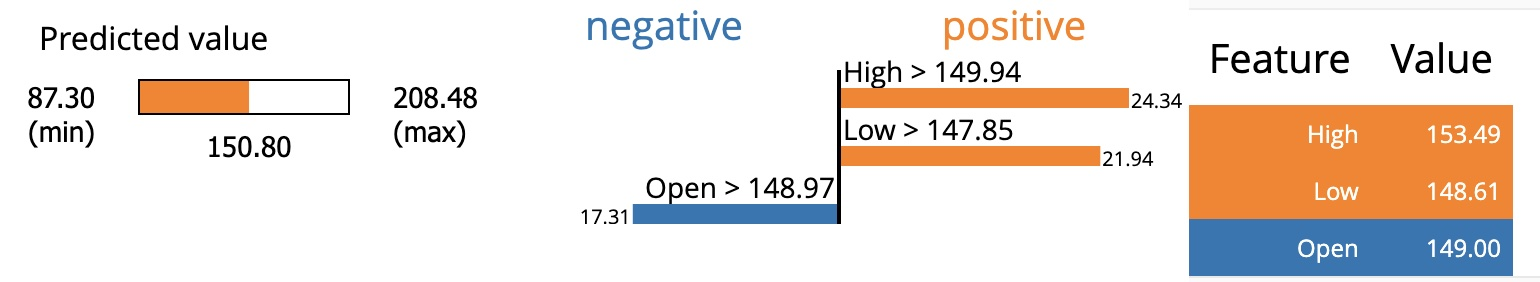

Positive/negative class in the case of regression, it refers to how LIME would approach explaining a regression model, which is slightly different than how it approaches classification models.

In a binary classification task, the concepts of positive and negative classes are straightforward, representing the two possible outcomes of the model (like 0 or 1, spam or not spam, etc.).



In regression tasks where the output is a continuous value, we don't have a notion of classes. Still, for the sake of interpretability, we might want to understand when the model tends to predict higher values (which we might loosely call the 'positive' class) versus when it predicts lower values (the 'negative' class).

LIME would then try to understand and explain which features contribute to the model predicting a higher (or 'positive') value and which features contribute to predicting a lower (or 'negative') value. It essentially interprets the regression task as two "classes" of prediction: higher than a certain value, and lower than a certain value.

Now, let's look at how to interpret the output:

- Predicted Value: The predicted value is the output of your model for the specific instance being explained. In other words, it's what your model predicts the target variable to be for the given input features.

- Feature Names: The feature names represent the different features in your dataset.

- Feature Values: The values listed next to each feature name are the actual values of those features in the instance being explained.

- Weights: The weights show the influence of each feature on the prediction. Features pushing the prediction higher are represented by positive weights, and features pushing the prediction lower are represented by negative weights. The magnitude of the weight corresponds to the strength of the influence.

- Positive/Negative Class: In the case of regression, we can think of the 'Positive' class as the predicted value being pushed higher, and the 'Negative' class as the predicted value being pushed lower.

- Graphical Representation: The bar chart visually represents the weights of the features. A bar extending to the right of the center indicates a positive weight (increasing the predicted value), while a bar extending to the left indicates a negative weight (decreasing the predicted value).

LIME provides a local interpretation of your model, explaining how each feature contributes to the prediction for a specific instance. This allows us to better understand the reasoning behind individual predictions made by our model.





